DOMAIN: Social media analytics

• CONTEXT: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

• DATA DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements

Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection
• PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.

Steps and tasks: [ Total Score: 30 points]
1. Read and explore the data 2. Retain relevant columns
3. Get length of each sentence 4. Define parameters
5. Get indices for words
6. Create features and labels
7. Get vocabulary size
8. Create a weight matrix using GloVe embeddings 9. Define and compile a Bidirectional LSTM model.
Hint: Be analytical and experimental here in trying new approaches to design the best model. 10. Fit the model and check the validation accuracy


### Import the libraries

In [27]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau 


import warnings
warnings.filterwarnings("ignore")


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the Dataset

In [29]:
df_News = pd.read_json('/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json', lines=True)
df_News.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [30]:
df_News.shape

(28619, 3)

### Exploratory Data Analysis

In [31]:
df_News.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [50]:
df_News.describe()

,is_sarcastic,headline_len
count,28619.000000,28619.000000
mean,0.476397,10.049967
std,0.499451,3.388307
min,0.000000,2.000000
25%,0.000000,8.000000
50%,0.000000,10.000000
75%,1.000000,12.000000
max,1.000000,151.000000


In [32]:
# looking at some sarcastic news
df_News[df_News.is_sarcastic == 1].head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...


In [33]:
# looking at some legitimate news
df_News[df_News.is_sarcastic == 0].head(5)

,is_sarcastic,headline,article_link
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


### Target Column Distribution

In [34]:
df_News.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

The dataset appears to be balanced for Sarcastic and legitimate news

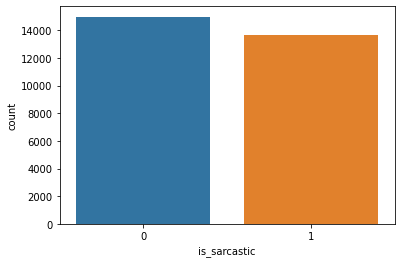

In [35]:
sns.countplot(df_News.is_sarcastic)

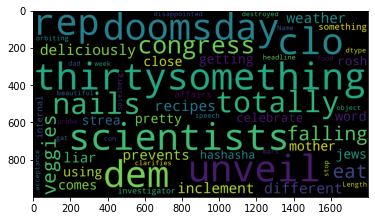

In [36]:
wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = 100,
                    random_state = 101, 
                    width=1800, 
                    height=1000)
wordcloud.generate(str(df_News['headline']))
plt.imshow(wordcloud)

### News Headline length Distribution

In [37]:
df_News['headline_len'] = df_News.headline.apply(lambda x: len(x.split()))

In [38]:
sarcastic = df_News[df_News.is_sarcastic == 1]
legit = df_News[df_News.is_sarcastic == 0]

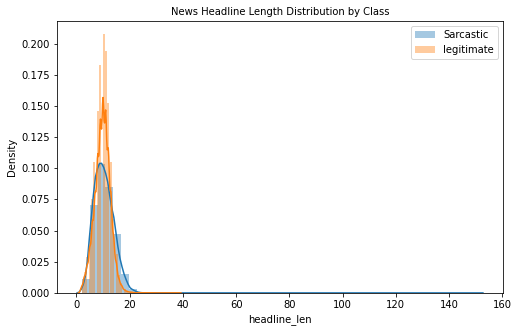

In [39]:
plt.figure(figsize=(8,5))
sns.distplot(sarcastic.headline_len, hist= True, label= 'Sarcastic')
sns.distplot(legit.headline_len, hist= True, label= 'legitimate')
plt.legend()
plt.title('News Headline Length Distribution by Class', fontsize = 10)
plt.show()

### Data Cleaning & Pre-processing

Pre-processing, as these are News Headlines which are written by Professionals in a formal way, so to not remove anything which can help with context, I will only remove punctuations and apply lemmatization

In [40]:
df_News = df_News.drop(columns=['article_link'])

In [41]:
import nltk

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
lem = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

In [74]:
def clean_text(news):
    """
    This function receives headlines sentence and returns clean sentence
    """
    news = news.lower()
    news = re.sub("\\n", "", news)
    #news = re.sub("\W+", " ", news)
    
    #Split the sentences into words
    words = list(news.split())
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in punctuations]
    words = [w for w in words if w not in stop_words]
    words = [''.join(x for x in w if x.isalpha()) for w in words]

    clean_sen = " ".join(words)
    
    return clean_sen

In [75]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#Note that the training data/test data split will be done later

num_words=20000
max_sentence_len=300
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(df_News["headline"]))
X=tokenizer.texts_to_sequences(list(df_News["headline"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(df_News["is_sarcastic"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 30884
The shape of the trainable data : (28619, 300)
The shape of the labels for the data is : (28619, 2)


In [65]:
nltk.download('wordnet')
nltk.download()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [78]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [79]:
df_News['news_headline'] = df_News.headline.apply(lambda news: clean_text(news)) 
df_News.head()

,is_sarcastic,headline,headline_len,news_headline
0,1,thirtysomething scientists unveil doomsday clo...,8,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,13,dem rep totally nail congress fall short gende...
2,0,eat your veggies: 9 deliciously different recipes,7,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,8,inclement weather prevent liar get work
4,1,mother comes pretty close to using word 'strea...,9,mother come pretty close use word streaming co...


In [80]:
df_News.groupby(['is_sarcastic']).headline_len.mean()

is_sarcastic
0     9.815616
1    10.307540
Name: headline_len, dtype: float64

In [81]:
df_News.groupby(['is_sarcastic']).headline_len.max()

is_sarcastic
0     38
1    151
Name: headline_len, dtype: int64

On an Average most of the headlines have same length, in some cases, Sarcastic headlines are longer. 

### Stratified Split 
Stratified split to sample approx equal number of instances for training for both the categories of our Target.

In [82]:
headlines = df_News['news_headline']
labels = df_News['is_sarcastic'] 

In [85]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(headlines, labels, test_size=0.2, stratify=labels, random_state=42)

In [86]:
train_labels.value_counts()

0    11988
1    10907
Name: is_sarcastic, dtype: int64

### Converting News Headlines into Sequences of tokens

In [87]:
#Defining Hyperparameters to be used

max_words = 30000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 70       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 100    # how big is each word vector

In [88]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [89]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [90]:
train_sequences

array([[ 4026,   917,  2786, ...,     0,     0,     0],
       [ 1913,  6270,  8056, ...,     0,     0,     0],
       [ 2005,  1094,   993, ...,     0,     0,     0],
       ...,
       [  991,  2613,   839, ...,     0,     0,     0],
       [  194, 11423,   245, ...,     0,     0,     0],
       [  101,    46,   605, ...,     0,     0,     0]], dtype=int32)

### Bidirectional LSTM

In [91]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model_bidir = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           3000000   
                                                                 
 bidirectional (Bidirectiona  (None, 70, 64)           34048     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [92]:
history_bidir = model_bidir.fit(train_sequences, train_labels, batch_size=32, epochs=10, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Epoch 1/10
716/716 [==============================] - 73s 96ms/step - loss: 0.5093 - accuracy: 0.7428 - val_loss: 0.4217 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 65s 91ms/step - loss: 0.2695 - accuracy: 0.8919 - val_loss: 0.4288 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 64s 89ms/step - loss: 0.1373 - accuracy: 0.9491 - val_loss: 0.5674 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/10
716/716 [==============================] - 63s 88ms/step - loss: 0.0597 - accuracy: 0.9808 - val_loss: 0.6994 - val_accuracy: 0.7975 - lr: 1.0000e-04
Epoch 5/10
716/716 [==============================] - 65s 91ms/step - loss: 0.0449 - accuracy: 0.9859 - val_loss: 0.7752 - val_accuracy: 0.7956 - lr: 1.0000e-04
Epoch 6/10
716/716 [==============================] - 64s 90ms/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.7874 - val_accuracy: 0.7947 - lr: 1.0000e-05
Epoch 7/10
716/716 [==========================

179/179 [==============================] - 3s 14ms/step - loss: 0.8046 - accuracy: 0.7951
Test Loss:  0.8046218156814575
Test Accuracy 0.795073390007019
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


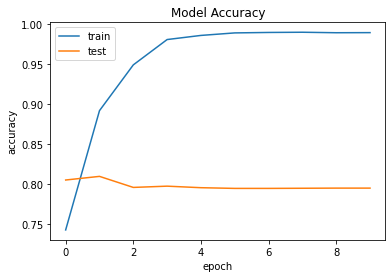

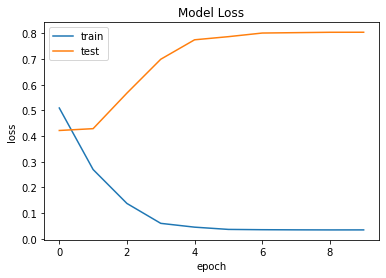

In [93]:
score = model_bidir.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_bidir.history.keys())
# summarize history for accuracy
plt.plot(history_bidir.history['accuracy'])
plt.plot(history_bidir.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bidir.history['loss'])
plt.plot(history_bidir.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Conclusion



Best test Accuracy - 85.81 %


# Conclusion:-
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.